In [1]:
import random
import numpy as np
from copy import deepcopy
from itertools import product
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import tracemalloc

In [2]:
V = {0, 1, 2, 3, 4, 5}
E = {(0,1), (0,2), (1,2), (1,3), (1,4), (3,5), (4,2), (4,3), (4,5)}
w = {
    (0,1): 2, 
    (0,2): 5, 
    (1,2): 2, 
    (1,3): 4, 
    (1,4): 3, 
    (3,5): 4, 
    (4,2): 2, 
    (4,3): 2, 
    (4,5): 6
}

G = (V,E,w,0, 5)

# Dijkstra's Algorithm

In [3]:
def dijkstra(V, E, w, s, t):
    
    l = {v: 0 if v == s else np.inf for v in V}
    p = {v: None for v in V}
    U = {s}
    u = s
    
    while True:
    
        # print(U, u)
    
        for v in V - U:
            if (u,v) in E and l[v] > l[u] + w[u,v]:
                p[v] = u
                l[v] = l[u] + w[u,v]
            
        m = min(l[v] for v in V - U)
        z = next(v for v in V - U if l[v] == m)
    
        U = U | {z}
        u = z
        
        # print(l)

        if U == V: # or all(l[v]==np.inf for v in V - U):
            break
            
    path = [t]

    while path[-1] != s:
        path.append(p[path[-1]])
    
    
    return l[t], list(reversed(path))

In [4]:
dijkstra(*G)

(10, [0, 1, 3, 5])

# Moore's Algorithm

In [5]:
def moore(V, E, w, s, t):
    
    alpha0 = 10
    
    l = {v : 0 if v == s else np.inf for v in V}
    a = {v : 0 if v == s else np.inf for v in V}
    p = {v : None for v in V}
    steps = 0
    ind = 0
    
    while True:
    
        ind = 0
        for u in V:
            if a[u] == steps:
                for (u, v) in E:
                    if l[v] > l[u] + w[u,v]:
                        ind = 1
                        l[v] = l[u] + w[u,v]
                        a[v] = a[u] + 1
                        p[v] = u
                    
        if ind == 0:
            break
        
        if ind == 1:
            steps += 1
            if steps > 1000:
                break
                
    path = [t]
    while path[-1] != s:
        path.append(p[path[-1]])
                
    return l[t], list(reversed(path))

In [6]:
moore(*G)

(10, [0, 1, 3, 5])

# Floyd-Warshall Algorithm

In [7]:
def floyd_warshall(V, E, w, s, t):
    
    L = [[w[i,j] if (i,j) in E else np.inf for j in V] for i in V]
    
    for i in V:
        for j in V:
            for k in V:
                L[j][k] = min(L[j][k], L[j][i] + L[i][k])
            
            if L[j][j] < 0:
                break # Cycle of negative length
                break
    
    return L[s][t]

In [8]:
floyd_warshall(*G)

10

In [9]:
def floyd_warshall_path(V, E, w, s, t):
    
    # https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm#Path_reconstruction
    
    l = { (u,v): np.inf for (u,v) in product(V,V) }
    p = { (u,v): None for (u,v) in product(V,V) }
    
    for u,v in E:
        l[u,v] = w[u,v]
        p[u,v] = v
        
    for v in V:
        l[v,v]=0
        p[v,v]=v
    
    for k in V:
        for i in V:
            for j in V:
                if l[i,j] > l[i,k] + l[k,j]:
                    l[i,j] = l[i,k] + l[k,j]
                    p[i,j] = p[i,k]
    
    if not p[u,v]:
        path = []
    else:
        u = s
        path = [s]
        while u != t:
            u = p[u,t]
            path.append(u)
    
                    
    return l[s,t], path

In [10]:
floyd_warshall_path(*G)

(10, [0, 1, 3, 5])

# Random Graph generation

* Clique: Fully connected graph with random uniform edge weights
* Grid: Graph layed out as a grid with random uniform edge weights
* Maze: Generation using Randomized Kruskal's algorithm (https://en.wikipedia.org/wiki/Maze_generation_algorithm)

## Clique generation

In [11]:
def generate_clique(n):
    
    V = set(range(n))
    E = { (u,v) for u,v in product(V,V) if u != v}
    w = { (u,v): np.random.random() for u,v in product(V, V) if u != v}
    s = 0
    t = n-1

    return (V,E,w,s,t)

## Grid generation

In [12]:
def neighbors(xy, n, m):

        x,y = xy
    
        if not (0 <= x < n and 0 <= y < m):
            return set()
    
        S = set()
        if x > 0:
            S.add((x-1, y))
        if x < n-1:
            S.add((x+1,y))
        if y > 0:
            S.add((x, y-1))
        if y < m-1:
            S.add((x, y+1))
        
        return S

In [13]:
def generate_grid(n, m):
    
    V = set(product(range(n), range(m)))
    E = { (v1,v2) for v1 in V for v2 in neighbors(v1, n, m) }
    w = { (u,v): np.random.random() for u,v in product(V, V) if u != v}
    s = (0,0)
    t = (n-1, m-1)
    
    return (V,E,w,s,t)

## Maze generation

In [14]:
def generate_maze(n, m):
    
    V = set(product(range(n), range(m)))
        
    walls = {frozenset({v1,v2}) for v1 in V for v2 in neighbors(v1, n, m)}
    partition = { v : {v} for v in V}

    for v1,v2 in random.sample(list(walls), len(walls)):
    
        if partition[v1] != partition[v2]:
         
            walls = walls - {frozenset({v1, v2})}
       
            joined = partition[v1] | partition[v2]
            for v in joined:
                partition[v] = joined
            
    E = { (v1,v2) for v1 in V for v2 in neighbors(v1, n, m) if frozenset({v1,v2}) not in walls}
    w = { (u,v): np.random.random() for u,v in product(V, V) if u != v}
    s = (0,0)
    t = (n-1, m-1)
    
    return (V,E,w,s,t)

# Plotting examples

In [15]:
n = 4
m = 4

In [16]:
Vk,Ek,wk,sk,tk = generate_clique(n*m)
_, pk = moore(Vk,Ek,wk,sk,tk)

In [17]:
Vg,Eg,wg,sg,tg = generate_grid(n,m)
_, pg = moore(Vg,Eg,wg,sg,tg)

In [18]:
Vm,Em,wm,sm,tm = generate_maze(n,m)
walls = {(v1,v2) for v1 in Vm for v2 in neighbors(v1, n, m) if not (v1,v2) in Em}
_, pm = moore(Vm,Em,wm,sm,tm)

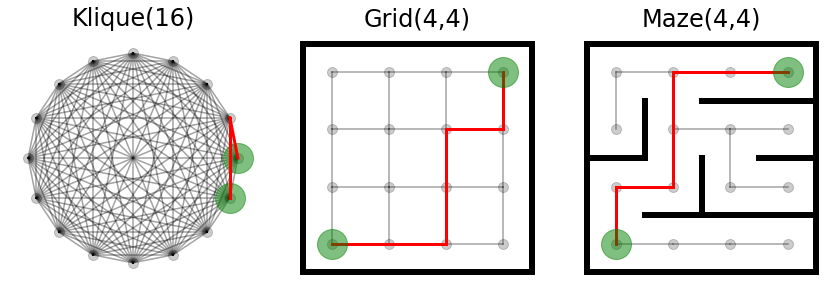

In [19]:
_, (ak, ag, am) = plt.subplots(1,3,figsize=(12,4))

# Plot grid
ag.plot([-0.5, n-0.5], [-0.5, -0.5], 'k-', linewidth=6)
ag.plot([-0.5, n-0.5], [m-0.5, m-0.5], 'k-', linewidth=6)
ag.plot([n-0.5, n-0.5], [-0.5, -0.5], 'k-', linewidth=6)
ag.plot([-0.5, -0.5], [-0.5, m-0.5], 'k-', linewidth=6)
ag.plot([n-0.5, n-0.5], [-0.5, m-0.5], 'k-', linewidth=6)

ag.plot([x for x,_ in Vg], [y for _,y in Vg], 'ko', alpha=.2, markersize=10)
for ((x1,y1),(x2,y2)) in Eg:
    ag.plot([x1, x2], [y1, y2], 'k-', alpha=.2)
        
for ((x1,y1),(x2,y2)) in zip(pg, pg[1:]):
    
    ag.plot([x1, x2], [y1, y2], 'r-', linewidth=3)
    
ag.plot([0, n-1], [0, m-1], 'go', markersize=30, alpha=0.5)


# Plot maze
am.plot([-0.5, n-0.5], [-0.5, -0.5], 'k-', linewidth=6)
am.plot([-0.5, n-0.5], [m-0.5, m-0.5], 'k-', linewidth=6)
am.plot([n-0.5, n-0.5], [-0.5, -0.5], 'k-', linewidth=6)
am.plot([-0.5, -0.5], [-0.5, m-0.5], 'k-', linewidth=6)
am.plot([n-0.5, n-0.5], [-0.5, m-0.5], 'k-', linewidth=6)

am.plot([x for x,_ in Vm], [y for _,y in Vm], 'ko', alpha=.2, markersize=10)
for ((x1,y1),(x2,y2)) in Em:
    am.plot([x1, x2], [y1, y2], 'k-', alpha=.2)
    
for ((x1,y1),(x2,y2)) in walls:
    
    if x1 == x2:
        plt.plot([x1-0.5, x1+0.5], [(y1 + y2)/2]*2, 'k-', linewidth=6)    

    if y1 == y2:
        plt.plot([(x1 + x2)/2]*2, [y1-0.5, y1+0.5], 'k-', linewidth=6)
        
for ((x1,y1),(x2,y2)) in zip(pm, pm[1:]):
    
    am.plot([x1, x2], [y1, y2], 'r-', linewidth=3)

am.plot([0, n-1], [0, m-1], 'go', markersize=30, alpha=0.5)

# Plot clique
coords = {i: (np.cos(float(i)/len(Vk)*2*np.pi), np.sin(float(i)/len(Vk)*2*np.pi)) for i in Vk}

ak.plot([coords[i][0] for i in Vk], [coords[i][1] for i in Vk], 'ko', alpha=.2, markersize=10)

for i, j in Ek:
    x1,y1 = coords[i]
    x2,y2 = coords[j]
    ak.plot([x1,x2], [y1,y2], 'k-', alpha=.2)
    
ak.set_xlim(-1.2,1.2)
ak.set_ylim(-1.2,1.2)

ak.plot([coords[sk][0], coords[tk][0]], [coords[sk][1], coords[tk][1]], 'go', markersize=30, alpha=0.5)

for i,j in zip(pk, pk[1:]):
    x1,y1 = coords[i]
    x2,y2 = coords[j]
    ak.plot([x1, x2], [y1, y2], 'r-', linewidth=3)
    

ak.set_title(f'Klique({n*m})', fontsize=24)
ag.set_title(f'Grid({n},{m})', fontsize=24)
am.set_title(f'Maze({n},{m})', fontsize=24)

ak.set_aspect('equal', adjustable='box')
ag.set_aspect('equal', adjustable='box')
am.set_aspect('equal', adjustable='box')

ak.axis('off')
ag.axis('off')
am.axis('off')

plt.tight_layout()

plt.savefig('plt_example.pdf')

# Benchmarking

In [20]:
n = 10
m = 10
repeats = 20

In [21]:
algorithms = [
    ('Dijkstra\'s Algorithmus', dijkstra),
    ('Moore\'s Algorithmus', moore),
    ('Floyd-Warshall Algorithmus', floyd_warshall_path),
]

In [22]:
graphs = [
    (f'{n*m}-Clique', lambda n, m: generate_clique(n*m)),
    (f'{n}x{m}-Grid', generate_grid),
    (f'{n}x{m}-Maze', generate_maze)
]

In [33]:
dft = pd.DataFrame()

for (alabel, algo), (glabel, graphgen) in list(product(algorithms, graphs)):
    
        print(f'{alabel} on {glabel}')
        
        for i in range(repeats):

            G = graphgen(n,m)
            
            measurement = %timeit -n 1 -r 1 -o algo(*G)
    
            for run in measurement.all_runs:
        
                row = pd.Series(dict(time=run, algorithm=alabel, graph=glabel))
                dft = dft.append(row, ignore_index=True)
                
        print('')

Dijkstra's Algorithmus on 100-Clique
6.22 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
5.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
3.1 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.52 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.35 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.37 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.43 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.45 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.33 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.45 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.35 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.24 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.47 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
2.35 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 l

238 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
232 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
254 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
230 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
232 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
257 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
255 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
252 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
238 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
231 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
211 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
230 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
242 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
213 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
250 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
221 ms ± 0 ns per loop (mean ± std. dev.

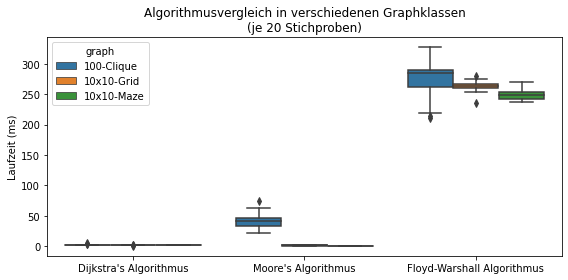

In [32]:
plt.subplots(1,1,figsize=(8, 4))
sns.boxplot(y=dft.time*1000, x=dft.algorithm, hue=dft.graph)
plt.title(f'Algorithmusvergleich in verschiedenen Graphklassen\n(je {repeats} Stichproben)')
plt.xlabel('')
plt.ylabel('Laufzeit (ms)')
plt.tight_layout()
plt.savefig('benchmark_execution_time.pdf')

### Memory usage

In [25]:
dfm = pd.DataFrame()
for alabel, algo in algorithms:
    for glabel, graphgen in graphs:        
        
        print(f'{alabel} on {glabel}')
        
        for i in range(repeats):
            
            G = graphgen(n,m)
            
            tracemalloc.start()
            algo(*G)
            mcurrent, mpeak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            
            print(mpeak)
            
            row = pd.Series(dict(mem_usage=mpeak, algorithm=alabel, graph=glabel))
            dfm = dfm.append(row, ignore_index=True)
                    
        print('')

Dijkstra's Algorithmus on 100-Clique
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
19263
18224
18551
18224

Dijkstra's Algorithmus on 10x10-Grid
18272
18248
18731
18248
19243
18551
18943
18224
18551
18224
18795
18224
18224
18224
18224
18272
18551
19007
18248
18248

Dijkstra's Algorithmus on 10x10-Maze
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224
18224

Moore's Algorithmus on 100-Clique
16344
16344
18680
16344
16344
16344
16344
16344
17619
16344
16344
16344
16344
16344
16344
16344
16344
16344
17619
16344

Moore's Algorithmus on 10x10-Grid
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
17479
16344
16344

Moore's Algorithmus on 10x10-Maze
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344
16344

Floyd-Warshall Algorithmus on 100-Clique
1822148
1820441
1820

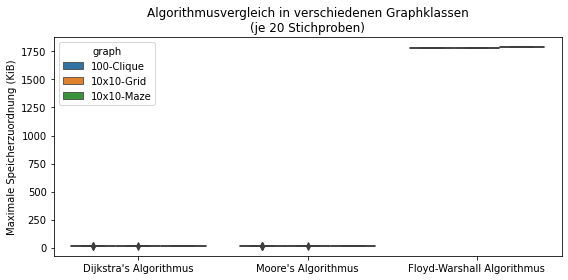

In [26]:
plt.subplots(1,1,figsize=(8, 4))
sns.boxplot(y=dfm.mem_usage / 1024, x=dfm.algorithm, hue=dfm.graph)
plt.title(f'Algorithmusvergleich in verschiedenen Graphklassen\n(je {repeats} Stichproben)')
plt.xlabel('')
plt.ylabel('Maximale Speicherzuordnung (KiB)')
plt.tight_layout()
plt.savefig('benchmark_memory.pdf')

### Path length

In [27]:
dfp = pd.DataFrame()
for alabel, algo in algorithms:
    for glabel, graphgen in graphs:        
        
        print(f'{alabel} on {glabel}')
        
        for i in range(repeats):
            
            G = graphgen(n,m)

            cumweight, path = algo(*G)
            print(len(path), cumweight)
            
            row = pd.Series(dict(pathweight=cumweight, pathlength=len(path), algorithm=alabel, graph=glabel))
            dfp = dfp.append(row, ignore_index=True)
                    
        print('')

Dijkstra's Algorithmus on 100-Clique
3 0.02618810043408437
5 0.06478807688047017
4 0.069221013599436
3 0.018365293177795228
9 0.08646716740873106
9 0.0625889420124025
3 0.04049666103349214
5 0.062373144477055664
4 0.048487970591649776
5 0.06716787997185725
9 0.05326997456994209
7 0.03917730256108487
8 0.039405140667576166
6 0.04815550262590418
5 0.07206648118618286
3 0.05038435917126649
6 0.08848013878629946
5 0.06754264478031735
2 0.018991682849469838
3 0.028870483242439016

Dijkstra's Algorithmus on 10x10-Grid
19 6.093171208079032
19 5.328759755907247
19 7.277595805765312
19 4.943314145361521
19 4.038147006798541
19 3.9843145410308307
19 3.4989886910088703
21 5.0245555751247775
19 4.635730534106512
21 6.4626433620030985
19 4.521082106790012
19 5.80969383932203
19 5.655950692986902
19 4.440518365421106
19 3.680748883597501
19 5.334052399644488
19 5.055017228980583
19 4.96874901955152
19 3.6725307023241083
19 6.092417023622437

Dijkstra's Algorithmus on 10x10-Maze
23 11.909591025408327

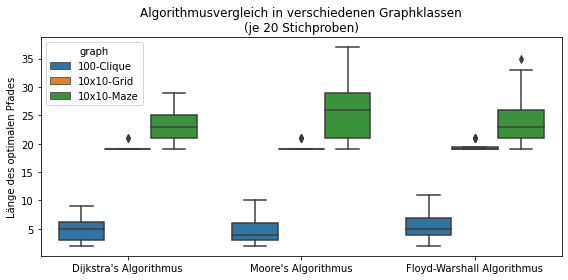

In [28]:
plt.subplots(1,1,figsize=(8, 4))
sns.boxplot(y=dfp.pathlength, x=dfp.algorithm, hue=dfp.graph)
plt.title(f'Algorithmusvergleich in verschiedenen Graphklassen\n(je {repeats} Stichproben)')
plt.xlabel('')
plt.ylabel('Länge des optimalen Pfades')
plt.tight_layout()
plt.savefig('benchmark_path_length.pdf')

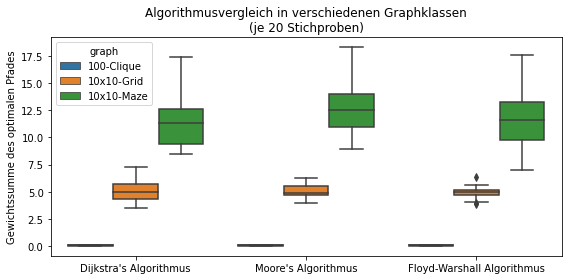

In [29]:
plt.subplots(1,1,figsize=(8, 4))
sns.boxplot(y=dfp.pathweight, x=dfp.algorithm, hue=dfp.graph)
plt.title(f'Algorithmusvergleich in verschiedenen Graphklassen\n(je {repeats} Stichproben)')
plt.xlabel('')
plt.ylabel('Gewichtssumme des optimalen Pfades')
plt.tight_layout()
plt.savefig('benchmark_path_weightsum.pdf')

In [30]:
dft.groupby(['algorithm', 'graph']) \
        .agg(lambda xs: f'{xs.mean()*1000:5.2f} $\pm$ {xs.std()*1000:5.2f}') \
        .rename(columns={'algorithm':'Algorithm', 'graph':'Graph', 'time':'Laufzeit (ms)'}) \
    .join(
        dfm.groupby(['algorithm', 'graph']) \
            .agg(lambda xs: f'{xs.mean()/1024:5.2f} $\pm$ {xs.std()/1024:5.2f}') \
            .rename(columns={'algorithm':'Algorithm', 'graph':'Graph', 'mem_usage':'Max. Speicher (KiB)'})
    ).join(
        dfp.groupby(['algorithm', 'graph']) \
            .agg(lambda xs: f'{xs.mean():5.2f} $\pm$ {xs.std():5.2f}') \
            .rename(columns={'algorithm':'Algorithm', 'graph':'Graph', 'pathlength':'Kanten in $\pi^*$', 'pathweight':'Gechwichtssumme von $\pi^*$'})
    )

Laufzeit (ms)  \
algorithm                  graph                            
Dijkstra's Algorithmus     100-Clique    2.24 $\pm$  0.13   
                           10x10-Grid    1.28 $\pm$  0.02   
                           10x10-Maze    1.25 $\pm$  0.03   
Floyd-Warshall Algorithmus 100-Clique  226.11 $\pm$  7.09   
                           10x10-Grid  254.40 $\pm$ 10.17   
                           10x10-Maze  231.68 $\pm$  4.98   
Moore's Algorithmus        100-Clique   42.21 $\pm$  9.45   
                           10x10-Grid    1.31 $\pm$  0.14   
                           10x10-Maze    0.78 $\pm$  0.10   

                                       Max. Speicher (KiB)  \
algorithm                  graph                             
Dijkstra's Algorithmus     100-Clique    17.86 $\pm$  0.23   
                           10x10-Grid    18.03 $\pm$  0.31   
                           10x10-Maze    17.80 $\pm$  0.00   
Floyd-Warshall Algorithmus 100-Clique  1778.66 $\pm$  0.79   
                           10x10-Grid  1783.17 $\pm$  0.18   
                           10x10-Maze  1786.30 $\pm$  0.10   
Moore's Algorithmus        100-Clique    16.20 $\pm$  0.61   
                           10x10-Grid    16.02 $\pm$  0.25   
                           10x10-Maze    15.96 $\pm$  0.00   

                                      Gechwichtssumme von $\pi^*$  \
algorithm                  graph                                    
Dijkstra's Algorithmus     100-Clique            0.05 $\pm$  0.02   
                           10x10-Grid            5.03 $\pm$  1.01   
                           10x10-Maze           11.43 $\pm$  2.35   
Floyd-Warshall Algorithmus 100-Clique            0.05 $\pm$  0.02   
                           10x10-Grid            4.92 $\pm$  0.60   
                           10x10-Maze           11.66 $\pm$  2.87   
Moore's Algorithmus        100-Clique            0.05 $\pm$  0.02   
                           10x10-Grid            5.05 $\pm$  0.61   
                           10x10-Maze           12.85 $\pm$  2.46   

                                       Kanten in $\pi^*$  
algorithm                  graph                          
Dijkstra's Algorithmus     100-Clique   5.20 $\pm$  2.21  
                           10x10-Grid  19.20 $\pm$  0.62  
                           10x10-Maze  23.60 $\pm$  2.76  
Floyd-Warshall Algorithmus 100-Clique   5.40 $\pm$  2.46  
                           10x10-Grid  19.50 $\pm$  0.89  
                           10x10-Maze  24.40 $\pm$  4.64  
Moore's Algorithmus        100-Clique   4.95 $\pm$  2.11  
                           10x10-Grid  19.40 $\pm$  0.82  
                           10x10-Maze  25.90 $\pm$  5.05